In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from confpred.cp import run_cp
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
dataset_list = ['CIFAR10','ImageNet','CIFAR100','NewsGroups']
seed = '23'
model_loss = 'softmax'
alpha_list = [0.01,0.05,0.1]
score_list = ['limit','opt_entmax','RAPS','sparsemax','softmax','entmax']
random_states = [1,12,123,1234,12345]
all_res_class_df = pd.DataFrame()
for alpha in alpha_list:
    for random_state in random_states:
        for dataset in dataset_list:
            for score in score_list:
                with open(f'../data/set_prediction/new/{dataset}_{score}_{seed}_{random_state}_alpha{alpha}_test_pred.pickle', 'rb') as handle:
                    test_preds = pickle.load(handle)
                path = f'../data/predictions/{dataset}_{seed}_test_true.pickle'
                with open(path, 'rb') as f:
                    test_true_enc_og = pickle.load(f)
                
                cal_size = np.ceil(test_true_enc_og.shape[0]*0.4).astype(int)
                test_true_enc = shuffle(test_true_enc_og,random_state = random_state)
                cal_true_enc = test_true_enc[0:cal_size]
                test_true_enc = test_true_enc[cal_size:]


                #test_match = test_pvalues>alpha
                test_match = test_preds
                set_size = test_match.sum(axis=1)
                test_bool = test_match[test_true_enc.astype(bool)]

                set_size_res = pd.DataFrame({'dataset':dataset,
                            'score':score,
                            'alpha':alpha,
                            'random_state':random_state,
                            'set_size':set_size,
                            'match':test_bool})
                all_res_class_df = pd.concat([all_res_class_df,set_size_res])

In [8]:
all_res_class_df['size_bin'] = pd.cut(all_res_class_df['set_size'],bins = [0,1,3,6,10,np.inf])
#imagenet_res = all_res_class_df[all_res_class_df['dataset']=='ImageNet']
grouped_df = all_res_class_df.groupby(['dataset','score','alpha','random_state','size_bin'])[['match']].agg(['mean','count'])

/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_40194/2891858572.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = all_res_class_df.groupby(['dataset','score','alpha','random_state','size_bin'])[['match']].agg(['mean','count'])


In [9]:
grouped_df_temp = grouped_df.reset_index().droplevel(1,axis=1)
grouped_df_temp[(grouped_df_temp['dataset']=='ImageNet')&(grouped_df_temp['random_state']==1)&(grouped_df_temp['alpha']==0.01)]

,dataset,score,alpha,random_state,size_bin,match,match
900,ImageNet,RAPS,0.01,1,"(0.0, 1.0]",NaN,0
901,ImageNet,RAPS,0.01,1,"(1.0, 3.0]",NaN,0
902,ImageNet,RAPS,0.01,1,"(3.0, 6.0]",NaN,0
903,ImageNet,RAPS,0.01,1,"(6.0, 10.0]",NaN,0
904,ImageNet,RAPS,0.01,1,"(10.0, inf]",0.989967,30000
975,ImageNet,entmax,0.01,1,"(0.0, 1.0]",1.000000,44
976,ImageNet,entmax,0.01,1,"(1.0, 3.0]",1.000000,1559
977,ImageNet,entmax,0.01,1,"(3.0, 6.0]",0.997691,5196
978,ImageNet,entmax,0.01,1,"(6.0, 10.0]",0.997363,7585
979,ImageNet,entmax,0.01,1,"(10.0, inf]",0.982070,15616


In [10]:
singleton_df = all_res_class_df[all_res_class_df['random_state']==1]
singleton_df['is_singleton'] = singleton_df['set_size']==1
singleton_df = singleton_df.groupby(['dataset','score','alpha'])[['is_singleton']].mean().join(singleton_df[singleton_df['is_singleton']].groupby(['dataset','score','alpha'])[['match']].mean()).reset_index()

/var/folders/q2/bjm3n1qd6jq1npksrk9n26nw0000gn/T/ipykernel_40194/796446943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singleton_df['is_singleton'] = singleton_df['set_size']==1


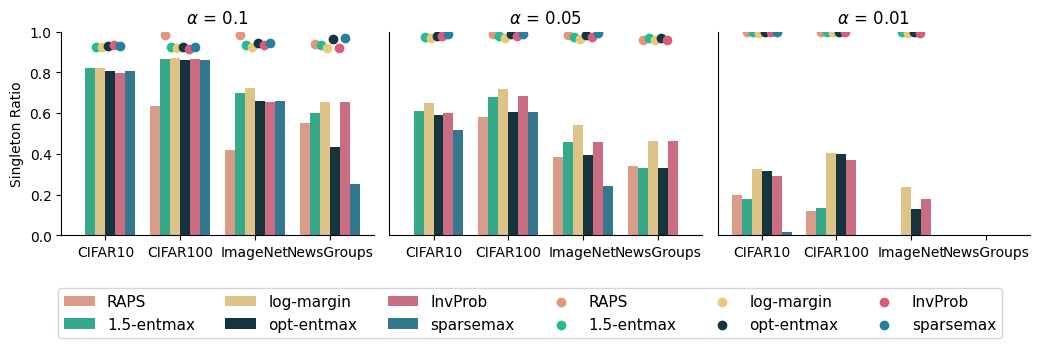

In [12]:
singleton_df['name'] = singleton_df['score'].map({'RAPS':'RAPS',
                                                        'sparsemax':'sparsemax',
                                                        'opt_entmax':'opt-entmax',
                                                        'softmax':'InvProb',      
                                                        'limit':'log-margin',   
                                                        'entmax':'1.5-entmax'
                                                    },na_action="ignore")
# Custom color map dictionary
color_map = {
    'InvProb': '#da5c7a',    # Red
    'RAPS': '#e5957c',       # Orange
    'log-margin': '#ecc979', # Yellow
    '1.5-entmax': '#22bc93', # Teal
    'sparsemax': '#24809e',  # Blue
    'opt-entmax': '#103743'  # Dark blue
}

# Legend labels corresponding to the 'name' column
legend_labels = ['InvProb', 'RAPS', 'log-margin', '1.5-entmax', 'sparsemax', 'opt-entmax']
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3))


for i, alpha in enumerate([0.1, 0.05, 0.01]):
    alp = singleton_df[singleton_df['alpha'] == alpha]
    
    # Plot the bars
    sns.barplot(data=alp, x='dataset', y='is_singleton', hue='name', palette=color_map, ax=axs[i], dodge=True)
    axs[i].set_title(r'$\alpha$ = ' + str(alpha))
    
    # Calculate offsets for scatter plot points (for dodging)
    hue_levels = alp['name'].unique()  # Get unique hue levels (categories)
    offsets = np.linspace(-0.2, 0.2, len(hue_levels))  # Create offsets for each category
    
    # Plot the scatter points manually by adjusting x positions
    for j, name in enumerate(hue_levels):
        subset = alp[alp['name'] == name]
        x_positions = np.arange(len(subset['dataset'].unique())) + offsets[j]  # Adjust x positions
        
        # Plot scatter points for this specific hue level
        axs[i].scatter(x_positions, subset['match'], label=name, color=color_map[name])
    
    # Customize axes and appearance
    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].get_legend().remove()
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_ylim(0, 1)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

# Set the common legend for the entire figure
fig.legend(handles, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 0.05), fontsize=11)

# Y-axis adjustments for the subplots
axs[0].set_ylabel('Singleton Ratio')
axs[1].set_yticks([])
axs[2].set_yticks([])

# Adjust layout
plt.subplots_adjust(bottom=0.2, wspace=0.05, hspace=0.4)

plt.show()
